In [16]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
from glob import glob
import numpy as np

In [2]:
ls ssrt_metrics

guesses.csv                    indiv_vanilla.csv
indiv_graded_mu_go_linear.csv  linear.csv
indiv_graded_mu_go_log.csv     log.csv
indiv_guesses.csv              vanilla.csv


In [3]:
example_data = pd.read_csv('ssrt_metrics/indiv_guesses.csv', index_col=0)
example_data.columns = example_data.columns.str.replace('SSRT_', '')
melt_df = pd.melt(example_data, id_vars=['SSD'], value_vars=['standard','w_guesses','w_graded'], var_name = 'assumed_go_dist', value_name='SSRT')

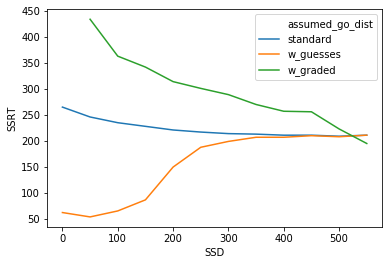

In [4]:
_ = sns.lineplot(x='SSD', y='SSRT', hue='assumed_go_dist', data=melt_df)

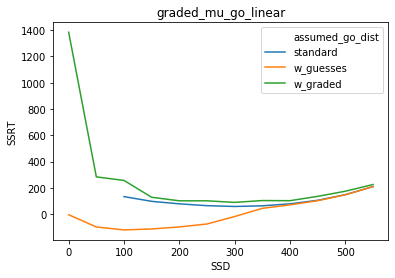

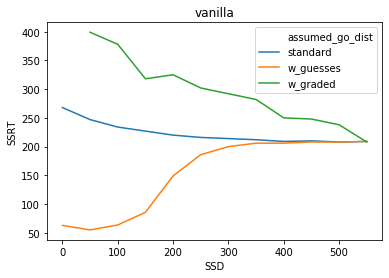

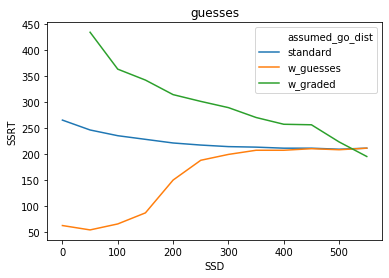

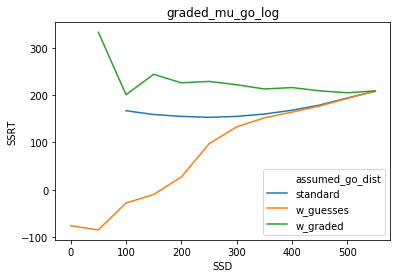

In [5]:
for file in glob('ssrt_metrics/indiv_*.csv'):
    data =  pd.read_csv(file, index_col=0)
    data.columns = data.columns.str.replace('SSRT_', '')
    melt_df = pd.melt(data, id_vars=['SSD'], value_vars=['standard','w_guesses','w_graded'], var_name = 'assumed_go_dist', value_name='SSRT')
    _ = sns.lineplot(x='SSD', y='SSRT', hue='assumed_go_dist', data=melt_df)
    plt.title(file.split('indiv_')[-1].replace('.csv', ''))
    plt.show()
    plt.close()

In [53]:
dd = {'help': 1, 'me': 0}

In [63]:
[v for v in dd.keys()] + ['blah']

['help', 'me', 'blah']

In [24]:
def generate_exgauss_sampler_from_fit(data,
                                      default_sample_size=100000):
    FIT_K, FIT_LOC, FIT_SCALE = sstats.exponnorm.fit(data)
    FIT_LAMBDA = 1/(FIT_K*FIT_SCALE)
    FIT_BETA = 1/FIT_LAMBDA

    print(FIT_LOC)
    def sample_exgauss(sample_size=default_sample_size,
                       beta=FIT_BETA, scale=FIT_SCALE, loc=FIT_LOC):
        exp_out = np.random.exponential(scale=beta, size=sample_size)
        norm_out = np.random.normal(scale=scale, size=sample_size)
        return (exp_out+norm_out) + loc

    return sample_exgauss

In [25]:
def get_args():
    parser = argparse.ArgumentParser(description='ABCD data simulations')
    parser.add_argument('--sim_dir', default='./simulated_data',
                        help='location of simulated data')
    parser.add_argument('--out_dir', default='./ssrt_metrics',
                        help='location to save ssrt metrics')
    args = parser.parse_args()
    return(args)


def generate_out_df(data, SSD_guess_dict):
    info = []
    ssrtmodel = SSRTmodel(model='replacement')
    goRTs = data.loc[data.goRT.notnull(), 'goRT'].values
    SSDs = [i for i in data.SSD.unique() if i == i]
    SSDs.sort()
    for SSD in SSDs:
        curr_df = data.query(
            "condition=='go' | condition=='stop' and SSD == %s" % SSD
            ).copy()
        curr_metrics = ssrtmodel.fit_transform(curr_df)

        goRTs_w_guesses = add_guess_RTs_and_sort(goRTs, SSD, SSD_guess_dict)
        SSRT_w_guesses = SSRT_wReplacement(curr_metrics, goRTs_w_guesses)

        goRTs_graded = simulate_graded_RTs_and_sort(1000, SSD)

        SSRT_w_graded = SSRT_wReplacement(curr_metrics, goRTs_graded)
        info.append([
            SSD,
            curr_metrics['SSRT'],
            SSRT_w_guesses,
            SSRT_w_graded
        ])
    return pd.DataFrame(
        info,
        columns=['SSD', 'SSRT_standard', 'SSRT_w_guesses', 'SSRT_w_graded'])


def add_guess_RTs_and_sort(goRTs, SSD, SSD_guess_dict):
    curr_n = len(goRTs)
    p_guess = SSD_guess_dict[SSD]
    if p_guess == 1.0:
        guess_RTs = sample_exgauss(curr_n)
        guess_RTs.sort()
        return guess_RTs
    else:
        # Equation logic:
        # p_guess = n_guess / (n_guess + curr_n) =>
        # n_guess = (p_guess * curr_n) / (1 - p_guess)
        n_guess = int(np.rint(float((p_guess*curr_n)/(1-p_guess))))
        guess_RTs = sample_exgauss(n_guess)
        all_RTs = np.concatenate([goRTs, guess_RTs])
        all_RTs.sort()
        return all_RTs


def simulate_graded_RTs_and_sort(n_trials, SSD):
    simulator = SimulateData()
    params = simulator._init_params({})
    params['n_trials_stop'] = n_trials
    params['n_trials_go'] = n_trials

    params['mu_go'] = simulator._log_mu_go(params['mu_go'], SSD)
    simulator._set_n_trials(params)
    simulator._set_n_guesses(params)  # no guessing is happening

    data_dict = simulator._simulate_go_trials(simulator._init_data_dict(),
                                              params)
    goRTs = data_dict['RT']
    goRTs.sort()
    return goRTs


def get_nth_RT(P_respond, goRTs):
    """Get nth RT based P(response|signal) and sorted go RTs."""
    nth_index = int(np.rint(P_respond*len(goRTs))) - 1
    if nth_index < 0:
        nth_RT = goRTs[0]
    elif nth_index >= len(goRTs):
        nth_RT = goRTs[-1]
    else:
        nth_RT = goRTs[nth_index]
    return nth_RT


def SSRT_wReplacement(metrics, sorted_go_RTs):
    P_respond = metrics['p_respond']
    goRTs_w_replacements = np.concatenate((
        sorted_go_RTs,
        [metrics['max_RT']] * metrics['omission_count']))

    nrt = get_nth_RT(P_respond, goRTs_w_replacements)

    return nrt - metrics['mean_SSD']

In [26]:
    # GET ABCD INFO
    abcd_data = pd.read_csv('abcd_data/minimal_abcd_no_issue_3.csv')

    SSDs = abcd_data.SSDDur.unique()
    SSDs = [i for i in SSDs if i == i]
    SSDs.sort()
    acc_per_SSD = pd.DataFrame()
    for ssd in SSDs:
        curr_means = abcd_data.query(
            "SSDDur == %s and correct_stop==0.0" % ssd
        ).groupby('NARGUID').mean()['choice_accuracy']
        curr_means.name = ssd
        acc_per_SSD = pd.concat([acc_per_SSD, curr_means], 1, sort=True)

    go_accs = abcd_data.query(
            "trial_type == 'GoTrial' and correct_go_response in ['1.0', '0.0']"
        ).groupby('NARGUID').mean()['choice_accuracy']
    go_accs.name = -1
    acc_per_SSD = pd.concat([acc_per_SSD, go_accs], 1, sort=True)

#     p = Symbol('p')
#     guess_mean = acc_per_SSD.mean()[0.0]
#     go_mean = acc_per_SSD.mean()[-1]
#     SSD_guess_dict = {}
#     for ssd in acc_per_SSD.columns:
#         curr_mean = acc_per_SSD.mean()[ssd]
#         solution = solve(p*guess_mean + (1-p)*go_mean - curr_mean, p)
#         assert len(solution) == 1
#         SSD_guess_dict[ssd] = solution[0]


    SSD0_RTs = abcd_data.query(
        "SSDDur == 0.0 and correct_stop==0.0"
        ).stop_rt_adjusted.values
    sample_exgauss = generate_exgauss_sampler_from_fit(SSD0_RTs)

223.32309726898626


In [20]:
sampled_rts = sample_exgauss(1500000)

In [21]:
np.min(sampled_rts)

-61.419569428541706

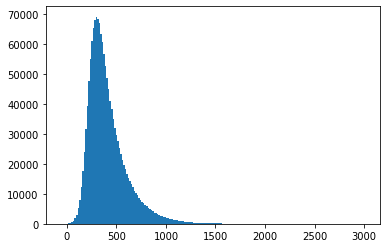

In [28]:
_ = plt.hist(sampled_rts, bins=200)

In [40]:
def generate_exgauss_sampler_from_fit(data,
                                      default_sample_size=100000):
    FIT_K, FIT_LOC, FIT_SCALE = sstats.exponnorm.fit(data)
    FIT_LAMBDA = 1/(FIT_K*FIT_SCALE)
    FIT_BETA = 1/FIT_LAMBDA

    print(FIT_SCALE)
    print(FIT_BETA)
    print(FIT_LOC)
    def sample_exgauss(sample_size=default_sample_size,
                       beta=FIT_BETA, scale=FIT_SCALE, loc=FIT_LOC):
        exp_out = np.random.exponential(scale=beta, size=sample_size) + loc
        norm_out = np.random.normal(scale=scale,loc=loc, size=sample_size)
        return norm_out + exp_out

    return sample_exgauss

64.81443224341497
186.1288941315643
223.32309726898626


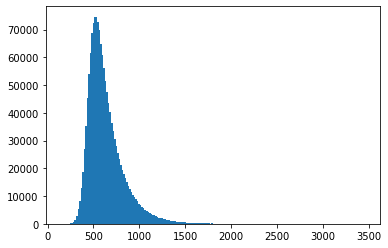

In [41]:
sample_exgauss = generate_exgauss_sampler_from_fit(SSD0_RTs)
sampled_rts = sample_exgauss(1500000)
_ = plt.hist(sampled_rts, bins=200)

In [43]:
np.mean(sampled_rts)

632.8092951513246

In [34]:
np.min(out)

0.003211734519176817

In [35]:
out = np.random.normal(scale=64.81443224341497, size=100000)

In [36]:
np.min(out)

-288.330273910476

In [44]:
ls simulated_data/

ABCD_SSD_group_guesses.csv          graded_mu_go.csv
ABCD_SSD_group_linear.csv           guesses.csv
ABCD_SSD_group_log.csv              individual_graded_mu_go_linear.csv
ABCD_SSD_group_vanilla.csv


In [45]:
eg_data = pd.read_csv('simulated_data/ABCD_SSD_group_guesses.csv', index_col=0)

In [48]:
len(eg_data.ID.unique())

53

In [52]:
eg_data.query("ID=='07XXFHDK'")

,condition,SSD,trial_idx,mu_go,mu_stop,accum_go,accum_stop,process_go,process_stop,block,goRT,stopRT,ID
0,stop,250.0,0,0.2,0.6,79.980563,103.559513,"[0.6716787215709914, 0, 0.852529058944238, 1.6...","[1.51364804693353, 2.6622628024842787, 0.56086...",0,NaN,NaN,07XXFHDK
1,stop,250.0,1,0.2,0.6,82.934652,100.929926,"[2.109408151698713, 2.944297986596167, 4.35939...","[0, 0, 2.0246299934642833, 3.9830287561911906,...",0,NaN,NaN,07XXFHDK
2,stop,250.0,2,0.2,0.6,100.929485,67.275007,"[0, 0, 0, 1.330641804697647, 0.283916408378975...","[0, 2.8201072063257846, 1.496362353487692, 1.7...",0,NaN,421.0,07XXFHDK
3,stop,250.0,3,0.2,0.6,101.186370,31.355909,"[0.22705619590086676, 0, 0, 0, 0.6947460205459...","[0, 0.2289634860357212, 2.1134343362744117, 1....",0,NaN,436.0,07XXFHDK
4,stop,250.0,4,0.2,0.6,101.151724,20.876415,"[0, 1.2592250450139164, 1.4674854252971128, 1....","[0.7572766145615446, 2.121583875763272, 3.1398...",0,NaN,330.0,07XXFHDK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,go,NaN,92,0.2,0.6,100.068056,0.000000,"[1.8949368723320217, 1.218426273767229, 0, 0, ...",[],0,765.0,NaN,07XXFHDK
1093,go,NaN,93,0.2,0.6,100.347639,0.000000,"[0, 0, 0, 0.815366620855974, 1.640738019403911...",[],0,522.0,NaN,07XXFHDK
1094,go,NaN,94,0.2,0.6,101.699713,0.000000,"[0, 2.9028149976084787, 2.8071298902841835, 3....",[],0,372.0,NaN,07XXFHDK
1095,go,NaN,95,0.2,0.6,100.369045,0.000000,"[0.6025854399889115, 0.8298091788399931, 2.151...",[],0,539.0,NaN,07XXFHDK


In [51]:
eg_data

,condition,SSD,trial_idx,mu_go,mu_stop,accum_go,accum_stop,process_go,process_stop,block,goRT,stopRT,ID
0,stop,300.0,0,0.2,0.6,102.376312,44.123778,"[2.1464595483972855, 2.377846572586949, 3.4690...","[0, 0, 2.200947016513533, 0, 0, 0.991037248942...",0,NaN,514.0,003RTV85
1,stop,300.0,1,0.2,0.6,101.841872,92.154841,"[1.5336943642413094, 3.057980725769716, 4.4671...","[1.009265904218811, 1.627824100729377, 2.12697...",0,NaN,566.0,003RTV85
2,stop,300.0,2,0.2,0.6,100.192248,0.000000,"[0, 0, 0.2443763282110159, 1.5655717813595684,...",[],0,NaN,334.0,003RTV85
3,stop,300.0,3,0.2,0.6,63.100423,101.043858,"[0, 0, 0.7186589204331486, 0.6140517694344834,...","[2.2333288137467147, 2.96967945372866, 5.14799...",0,NaN,NaN,003RTV85
4,stop,300.0,4,0.2,0.6,87.900546,100.249077,"[1.2044460604151221, 0.5557843347547126, 0.980...","[0.546311841687819, 0.323775340354971, 0, 1.30...",0,NaN,NaN,003RTV85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,go,NaN,92,0.2,0.6,100.068056,0.000000,"[1.8949368723320217, 1.218426273767229, 0, 0, ...",[],0,765.0,NaN,07XXFHDK
1093,go,NaN,93,0.2,0.6,100.347639,0.000000,"[0, 0, 0, 0.815366620855974, 1.640738019403911...",[],0,522.0,NaN,07XXFHDK
1094,go,NaN,94,0.2,0.6,101.699713,0.000000,"[0, 2.9028149976084787, 2.8071298902841835, 3....",[],0,372.0,NaN,07XXFHDK
1095,go,NaN,95,0.2,0.6,100.369045,0.000000,"[0.6025854399889115, 0.8298091788399931, 2.151...",[],0,539.0,NaN,07XXFHDK
